In [75]:
!pip install pymc

In [76]:
import numpy as np
from matplotlib import pyplot as plt
import pymc as pm

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Output()

Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


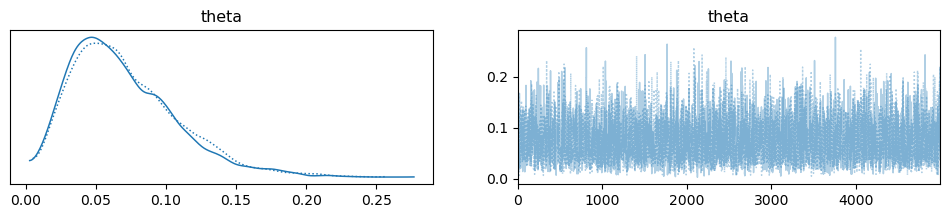

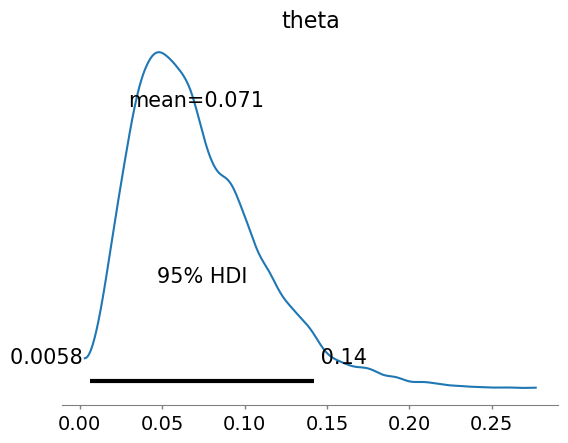

In [97]:
N = 40 # アリスのデザインA案の表示回数
a = 2 # アリスのデザインA案のクリック数

with pm.Model() as model:
    theta = pm.Uniform("theta", lower = 0, upper = 1)
    obs = pm.Binomial("a", p = theta, n = N, observed = a)
    trace = pm.sample(5000, chains = 2)

with model:
    pm.plot_trace(trace)

with model:
    pm.plot_posterior(trace, hdi_prob = 0.95)

In [98]:
with model:
    print(pm.summary(trace, hdi_prob = 0.95))

        mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
theta  0.071  0.038     0.006      0.142      0.001      0.0    3673.0   

       ess_tail  r_hat  
theta    4313.0    1.0  


In [101]:
# 仮説: アリスのデザインA案のクリック率は1%以上である
# 評価: 新たな確率変数δ = θ - 0.01のサンプルが95%の確率で正の値になる
# 結果: 0.992のため、アリスのデザインA案のクリック率は1%以上である
with model:
    print((trace.posterior["theta"] - 0.01 > 0).mean())

<xarray.DataArray 'theta' ()> Size: 8B
array(0.992)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Output()

Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


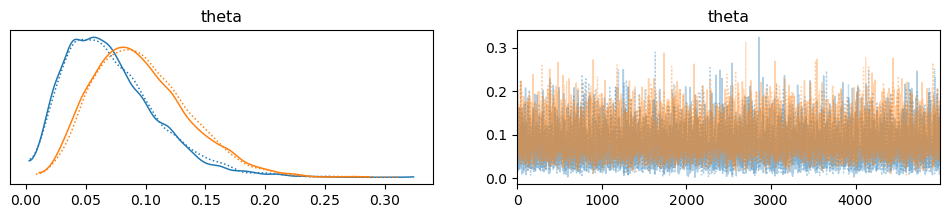

In [102]:
# A案とB案を同時に指定
with pm.Model() as alice_model:
    theta = pm.Uniform("theta", lower = 0, upper = 1, shape = 2)
    obs = pm.Binomial("obs", p = theta, n = [40, 50], observed = [2, 4])
    trace = pm.sample(5000, chains = 2)

with alice_model:
    pm.plot_trace(trace, ["theta"], compact = True)

In [104]:
# 仮説: デザインB案のクリック率はデザインA案よりも大きい
# 評価: δ = θb - θaのサンプルが95%の確率で正の値になる
with alice_model:
    print((trace.posterior['theta'][:, :, 1] - trace.posterior['theta'][:, :, 0] > 0).mean())

<xarray.DataArray 'theta' ()> Size: 8B
array(0.683)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Output()

Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


<xarray.DataArray 'theta' ()> Size: 8B
array(0.9995)


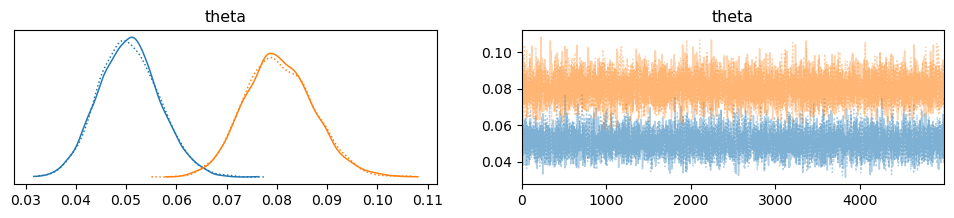

In [109]:
# ボブのデザイン案
with pm.Model() as bob_model:
    theta = pm.Uniform("theta", lower = 0, upper = 1, shape = 2)
    obs = pm.Binomial("obs", p = theta, n = [1280, 1600], observed = [64, 128])
    trace = pm.sample(5000, chains = 2)
    print((trace.posterior['theta'][:, :, 1] - trace.posterior['theta'][:, :, 0] > 0).mean())
    pm.plot_trace(trace, ["theta"], compact = True)